In [99]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn_utils import *
from tensorflow_utils import *

import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import scipy
import math
import joblib


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and  Split Kaggle Data

In [2]:
data_filename  = '../data/train.csv'
data_df = pd.read_csv(data_filename)
corpus = data_df['Comment']
labels = data_df['Insult']
train_corpus, test_corpus, train_labels, test_labels = \
sklearn.cross_validation.train_test_split(corpus, labels, test_size=0.33)

## Build baseline text classification model in Sklearn

In [4]:
pipeline = Pipeline([
    ('vect', sklearn.feature_extraction.text.CountVectorizer()),
    ('tfidf', sklearn.feature_extraction.text.TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', sklearn.linear_model.LogisticRegression()),
])

In [28]:
param_grid = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (2, 2), (1,4)),  # unigrams or bigrams
    #'vect_lowercase': (True, False),
    'vect__analyzer' : ('char',), #('word', 'char')
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
    'clf__C': [0.1, 1, 5,  50, 100, 1000, 5000],
}

model = cv (train_corpus, train_labels.values, 5, pipeline, param_grid, 'roc_auc', False, n_jobs=8)




Doing Gridsearch

Best Model Train AUC: 0.999258
Best Model Train F1 0.965159
Best Model Train Accuracy 0.982224

Best parameters set found:
{'clf__C': 5, 'vect__ngram_range': (1, 4), 'vect__analyzer': 'char'} 0.898481329938


Grid scores:
0.72558 (+/-0.00543) for {'clf__C': 0.1, 'vect__ngram_range': (1, 1), 'vect__analyzer': 'char'}
0.82944 (+/-0.00592) for {'clf__C': 0.1, 'vect__ngram_range': (2, 2), 'vect__analyzer': 'char'}
0.85762 (+/-0.00675) for {'clf__C': 0.1, 'vect__ngram_range': (1, 4), 'vect__analyzer': 'char'}
0.74702 (+/-0.00341) for {'clf__C': 1, 'vect__ngram_range': (1, 1), 'vect__analyzer': 'char'}
0.85406 (+/-0.00708) for {'clf__C': 1, 'vect__ngram_range': (2, 2), 'vect__analyzer': 'char'}
0.89102 (+/-0.00342) for {'clf__C': 1, 'vect__ngram_range': (1, 4), 'vect__analyzer': 'char'}
0.74954 (+/-0.00486) for {'clf__C': 5, 'vect__ngram_range': (1, 1), 'vect__analyzer': 'char'}
0.84478 (+/-0.01045) for {'clf__C': 5, 'vect__ngram_range': (2, 2), 'vect__analyzer': 'char'}

In [98]:
# Hold out set Perf
auc(test_labels.values,get_scores(model, test_corpus))

ROC: 0.89864 



0.89863847165913557

This is about as good as the best Kagglers report they did.

In [100]:
joblib.dump(model, '../models/kaggle_ngram.pkl')

['../models/kaggle_ngram.pkl',
 '../models/kaggle_ngram.pkl_01.npy',
 '../models/kaggle_ngram.pkl_02.npy',
 '../models/kaggle_ngram.pkl_03.npy',
 '../models/kaggle_ngram.pkl_04.npy',
 '../models/kaggle_ngram.pkl_05.npy',
 '../models/kaggle_ngram.pkl_06.npy',
 '../models/kaggle_ngram.pkl_07.npy',
 '../models/kaggle_ngram.pkl_08.npy',
 '../models/kaggle_ngram.pkl_09.npy',
 '../models/kaggle_ngram.pkl_10.npy',
 '../models/kaggle_ngram.pkl_11.npy',
 '../models/kaggle_ngram.pkl_12.npy',
 '../models/kaggle_ngram.pkl_13.npy',
 '../models/kaggle_ngram.pkl_14.npy',
 '../models/kaggle_ngram.pkl_15.npy',
 '../models/kaggle_ngram.pkl_16.npy',
 '../models/kaggle_ngram.pkl_17.npy',
 '../models/kaggle_ngram.pkl_18.npy',
 '../models/kaggle_ngram.pkl_19.npy',
 '../models/kaggle_ngram.pkl_20.npy',
 '../models/kaggle_ngram.pkl_21.npy',
 '../models/kaggle_ngram.pkl_22.npy',
 '../models/kaggle_ngram.pkl_23.npy',
 '../models/kaggle_ngram.pkl_24.npy',
 '../models/kaggle_ngram.pkl_25.npy',
 '../models/kaggle_

# Score Random Wikipedia User Talk Comments

Lets take a random sample of user talk comments, apply the insult model trained on kaggle and see what we find.

In [71]:
d_wiki = pd.read_csv('../../wikipedia/data/100k_user_talk_comments.tsv', sep = '\t').dropna()[:10000]

In [72]:
d_wiki['prob'] = model.predict_proba(d_wiki['diff'])[:,1]
d_wiki.sort('prob', ascending=False, inplace = True)

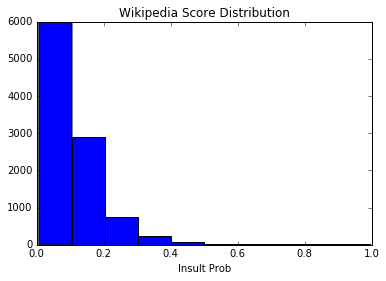

In [79]:
_ = plt.hist(d_wiki['prob'].values)
plt.xlabel('Insult Prob')
plt.title('Wikipedia Score Distribution')

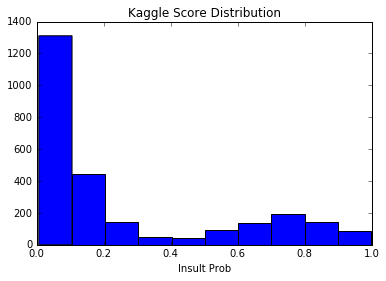

In [80]:
_ = plt.hist(model.predict_proba(train_corpus)[:, 1])
plt.xlabel('Insult Prob')
plt.title('Kaggle Score Distribution')

 The distribution over insult probabilities in the two datasets is radically different. Insults in the Wikipedia dataset are much rarer

In [88]:
"%0.2f%% of random wiki comments are predicted to be insults" % ((d_wiki['prob'] > 0.5).mean() * 100)

'0.83% of random wiki comments are predicted to be insults'

### Check High Scoring Comments

In [51]:
for i in range(5):
    print(d_wiki.iloc[i]['prob'], d_wiki.iloc[i]['diff'], '\n')

0.994776188204 Fuck You Stupid NG 

0.992150341104  Fuck you  Go stick your foot up your ass, you bastard nazi. 

0.984552552305 Fuck You 

0.974815537861  you little bitch    

0.973793286927 fuck you. 



In [54]:
for i in range(50, 55):
    print(d_wiki.iloc[i]['prob'], d_wiki.iloc[i]['diff'], '\n')

0.69518887229 I don't like you Cluebot. 

0.689035760688  Xiadus   Why did you remove it ya fuck     

0.688844434718  hey you  you are a jackass for taking my edit back. Howard Stern created the features of iowa. 

0.679240067946  You added "All I Ask" to your user page saying you created it. You didn't create the article, and you're not the first person to add prose to it.  —    

0.678999793678 Boo! You suck! 



In [57]:
for i in range(100, 105):
    print(d_wiki.iloc[i]['prob'], d_wiki.iloc[i]['diff'], '\n')

0.54065517874 fuck this shit bitch man it feels good to be a gangsta 

0.540179092831 When you add things like you did to Talk:Maxi yacht 

0.539896950103  You are a fan of Himmler  Bad thing 

0.538296060837 If you work for Eagle Radio, you will need to clearly state that on your user page; please review this page for more information.    

0.535843828806 25px|alt=Warning icon Please stop your disruptive editing. If you continue to remove speedy deletion notices from pages you created yourself, as you did at :Anu Autoclave & Incin. Services, you may be blocked from editing.     



# Score Blocked Users' User Talk Comments

In [83]:
d_wiki_blocked = pd.read_csv('../../wikipedia/data/blocked_users_user_talk_page_comments.tsv', sep = '\t').dropna()[:10000]

In [92]:
d_wiki_blocked['prob'] = model.predict_proba(d_wiki_blocked['diff'])[:,1]
d_wiki_blocked.sort('prob', ascending=False, inplace = True)

In [93]:
"%0.2f%% of random wiki comments are predicted to be insults" % ((d_wiki_blocked['prob'] > 0.5).mean() * 100)

'3.69% of random wiki comments are predicted to be insults'

### Check High Scoring Comments

In [95]:
for i in range(5):
    print(d_wiki_blocked.iloc[i]['prob'], d_wiki_blocked.iloc[i]['diff'], '\n')

0.999401502135  fuck you  you're an idiot 

0.99930438266 FUCK YOU FUCKIN ASSHOLE SO FUCK YOU FUCK YOU RETARD MORON YOU PIECE A SHIT 

0.994985168036  FUCK YOU  

0.994985168036  FUCK YOU  

0.994985168036  FUCK YOU  



In [96]:
for i in range(50, 55):
    print(d_wiki_blocked.iloc[i]['prob'], d_wiki.iloc[i]['diff'], '\n')

0.92569576008 fuck off anusial 

0.923027207676   I love how you act like an innocent little baby, you remove my edits and hide behind "your own edits", can you stop acting like a snake moving and slithering in the grass and man up for once, and stop with accusation that have no grounds, it just shows you how childish you are, if you think I was being POV, please provide your evidence and let's discuss it. Until then better shut your mouth boy.    

0.922799651823 faggggot 

0.922633390355 ????!!!!! YOU ARE ADDING UNSOURCED INFORMATION!!!!!! DOES NOT EXIST ON THE ARTICLE YOU ARE QUOTING!!!!!! WHY THE HELL WONT YOU CHECK BEFORE REVERTING THIS IS INSANE!!!!! 

0.918644613731 Jesus fucking christ, you're a goddamn wikinazi. 



In [97]:
for i in range(100, 105):
    print(d_wiki_blocked.iloc[i]['prob'], d_wiki.iloc[i]['diff'], '\n')

0.82503034387  editing Sage Northcutt UFC page  So you edited the Sage Northcutt UFC page, yet kept my old citations with CORRECT info.  How does the info match up to the citations now??? You are a phagg0t.  Learn to read and cite correctly, you idiot. 

0.824529747531 You can only control your behavior. Don't fight fire with fire. The fact that you are an IP is not relevant.    

0.824307698869  Your psychology?  Seriously, what's wrong with you?  What is your significant emotional deficiency that makes you act out in the manner that you do?  What is it?  Why do you insist on this insane behaviour?  I'd like to help you as you are a seriously angry guy.  Why do you waste your own time, my time, everyone else's time by changing things to reflect incorrect information, then threaten me and continue to harass me for months now?  What charge do you get out of it?  Do you ever wake up in the AM and ask yourself, "Why did I do that?"  You really need help.  Talk to me.  I'm here for you.  I

# Scratch: Do not keep reading :)

#### Tensorflow MPL

In [140]:
isinstance(y_train, np.ndarray)

True

In [145]:
y_train = np.array([y_train, 1- y_train]).T
y_test = np.array([y_test, 1- y_test]).T

In [157]:
# Parameters
learning_rate = 0.001
training_epochs = 60
batch_size = 200
display_step = 5

# Network Parameters
n_hidden_1 = 100 # 1st layer num features
n_hidden_2 = 100 # 2nd layer num features
n_hidden_3 = 100 # 2nd layer num features
n_input = X_train.shape[1]
n_classes = 2 

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

# Create model
def LG(_X, _weights, _biases):
    return tf.matmul(_X, _weights['out']) + _biases['out']

# Store layers weight & bias
weights = {
    'out': tf.Variable(tf.random_normal([n_input, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = LG(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y)) # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph

sess = tf.Session()

sess.run(init)

# Training cycle
for epoch in range(training_epochs):
    avg_cost = 0.
    m = 0
    batches = batch_iter(X_train.toarray(), y_train, batch_size)
    # Loop over all batches
    for batch_xs, batch_ys in batches:
        batch_m = len(batch_ys)
        m += batch_m
        # Fit training using batch data
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys})
        # Compute average loss
        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys}) * batch_m
    # Display logs per epoch step
    if epoch % display_step == 0:
        print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost/m))
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Accuracy:", accuracy.eval({x: X_train.toarray(), y: y_train}, session=sess))
        print ("Accuracy:", accuracy.eval({x: X_test.toarray(), y: y_test}, session=sess))    
        
        
print ("Optimization Finished!")
# Test model


Epoch: 0001 cost= 0.858585700
Accuracy: 0.542738
Accuracy: 0.53185
Epoch: 0006 cost= 0.620715947
Accuracy: 0.681921
Accuracy: 0.653108
Epoch: 0011 cost= 0.538689288
Accuracy: 0.732602
Accuracy: 0.692249
Epoch: 0016 cost= 0.474780355
Accuracy: 0.77534
Accuracy: 0.702993
Epoch: 0021 cost= 0.420612711
Accuracy: 0.805598
Accuracy: 0.71604
Epoch: 0026 cost= 0.374425979
Accuracy: 0.831316
Accuracy: 0.72218
Epoch: 0031 cost= 0.335023997
Accuracy: 0.860439
Accuracy: 0.728319
Epoch: 0036 cost= 0.300916263
Accuracy: 0.88351
Accuracy: 0.729087
Epoch: 0041 cost= 0.271585224
Accuracy: 0.904312
Accuracy: 0.738296
Epoch: 0046 cost= 0.246153700
Accuracy: 0.92171
Accuracy: 0.740599
Epoch: 0051 cost= 0.223596772
Accuracy: 0.934947
Accuracy: 0.747506
Epoch: 0056 cost= 0.204010803
Accuracy: 0.944024
Accuracy: 0.750576
Optimization Finished!
